# Starting with DReAMy: encoding, reduction and visualisation

In this notebook, we will start using DReAMy and its basic funcionality. That is, downloading data, collecting embeddings for (some) dream reports, reducing the embeddings sapce and searching for significant patterns in the reduced space. 

In [ ]:
import sys
sys.executable

'/Users/lb540/miniconda3/envs/dreamypy_test/bin/python'

In [ ]:
%config Completer.use_jedi = False

In [ ]:
# import dreamy
from DReAMy import dreamy

Let's start by getting some dreams. You can stard by dowloading a collection of dream-reports scraped from the DreamBank database, freely availabe from DReAMy's hugging face! 

DReAMy has direct access to two datasets. A smaller English-only (~ 20k), and a larger and multiplingual one (En/De, ~ 30 k). We will start with the En-Only one, has it has descriptive variables (such as gender and year). 

In [ ]:
# choose between base (~ 22k reports, EN-only & more descriptive variables) 
# large (~ 29k reports, reports in EN and De, only series as descriptive variables)
database   = "base" 
dream_bank = dreamy.get_HF_DreamBank(database=database, as_dataframe=True)

Using custom data configuration DReAMy-lib--DreamBank-dreams-en-98a9abc92d226c3a
Found cached dataset parquet (/Users/lb540/.cache/huggingface/datasets/DReAMy-lib___parquet/DReAMy-lib--DreamBank-dreams-en-98a9abc92d226c3a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

As you can see, the file, dowloaded directlty as a pandas DataFrame, as three entires:
- dreams, the dream-reports
- series, the different collection of DreamBank
- description, a brief description of each series

In [ ]:
dream_bank.sample(2)

,series,description,dreams,gender,year
5629,jasmine2,Jasmine 2: high school,(2003-04-01)[started mid-sentence] ... came fr...,female,2001-2003
14278,hall_female,"College women, late 1940s",I was in a huge school gym which resembled the...,female,1946-1950


Lets now sample a small set of dreams. If you have a more powerfull machine (or you are working on Colab), you can increase the number of report. Note than the whole dataset contains ~ 29 k reports.

In [ ]:
n_samples = 1000
dream_sample = dream_bank.sample(n_samples).reset_index(drop=True)

Now we get the reports as a list, and use the `.get_encodings` functions of dreamy to extract the encodings. The encodings are the the `[CLS]` token of an LLM. At the moment, you can chose betweem four models, that are combination of small/large Engish-ony/multilingual (BERT / XLM-R).

In [ ]:
model_size = "small"   # or large
model_lang = "english" # or multi, for multilingual
device     = "cpu"    # "cpu" for loca/cpu, "cuda" for GPUs

In [ ]:
reports_list       = dream_sample["dreams"].tolist()
report_encodings = dreamy.get_encodings(
    reports_list, 
    model_size=model_size,
    language=model_lang, 
    device=device,
)

Loading/Downloading model and tokenizer


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


100%|███████████████████████████████████████| 1000/1000 [09:52<00:00,  1.69it/s]


Now that we have our embeddings for each report, we can use the `reduce_space` space function of dreamy. Available method are (for now) limited to `pca` and `t-sne`

In [ ]:
X, Y = dreamy.reduce_space(report_encodings, method="pca")

After collecting the cooordinates of the reduced space, we can update the `DataFrame` of our selected sample with them so to facilitate plotting the obtained results.

In [ ]:
dream_sample["DR_X"], dream_sample["DR_Y"] = X, Y

To visualise the resuced spece, we will make use of `seabonr`, since it well integrates with pandas. We will plot the 2-D space as a scatter plot, and use the different series as hue.

In [ ]:
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")

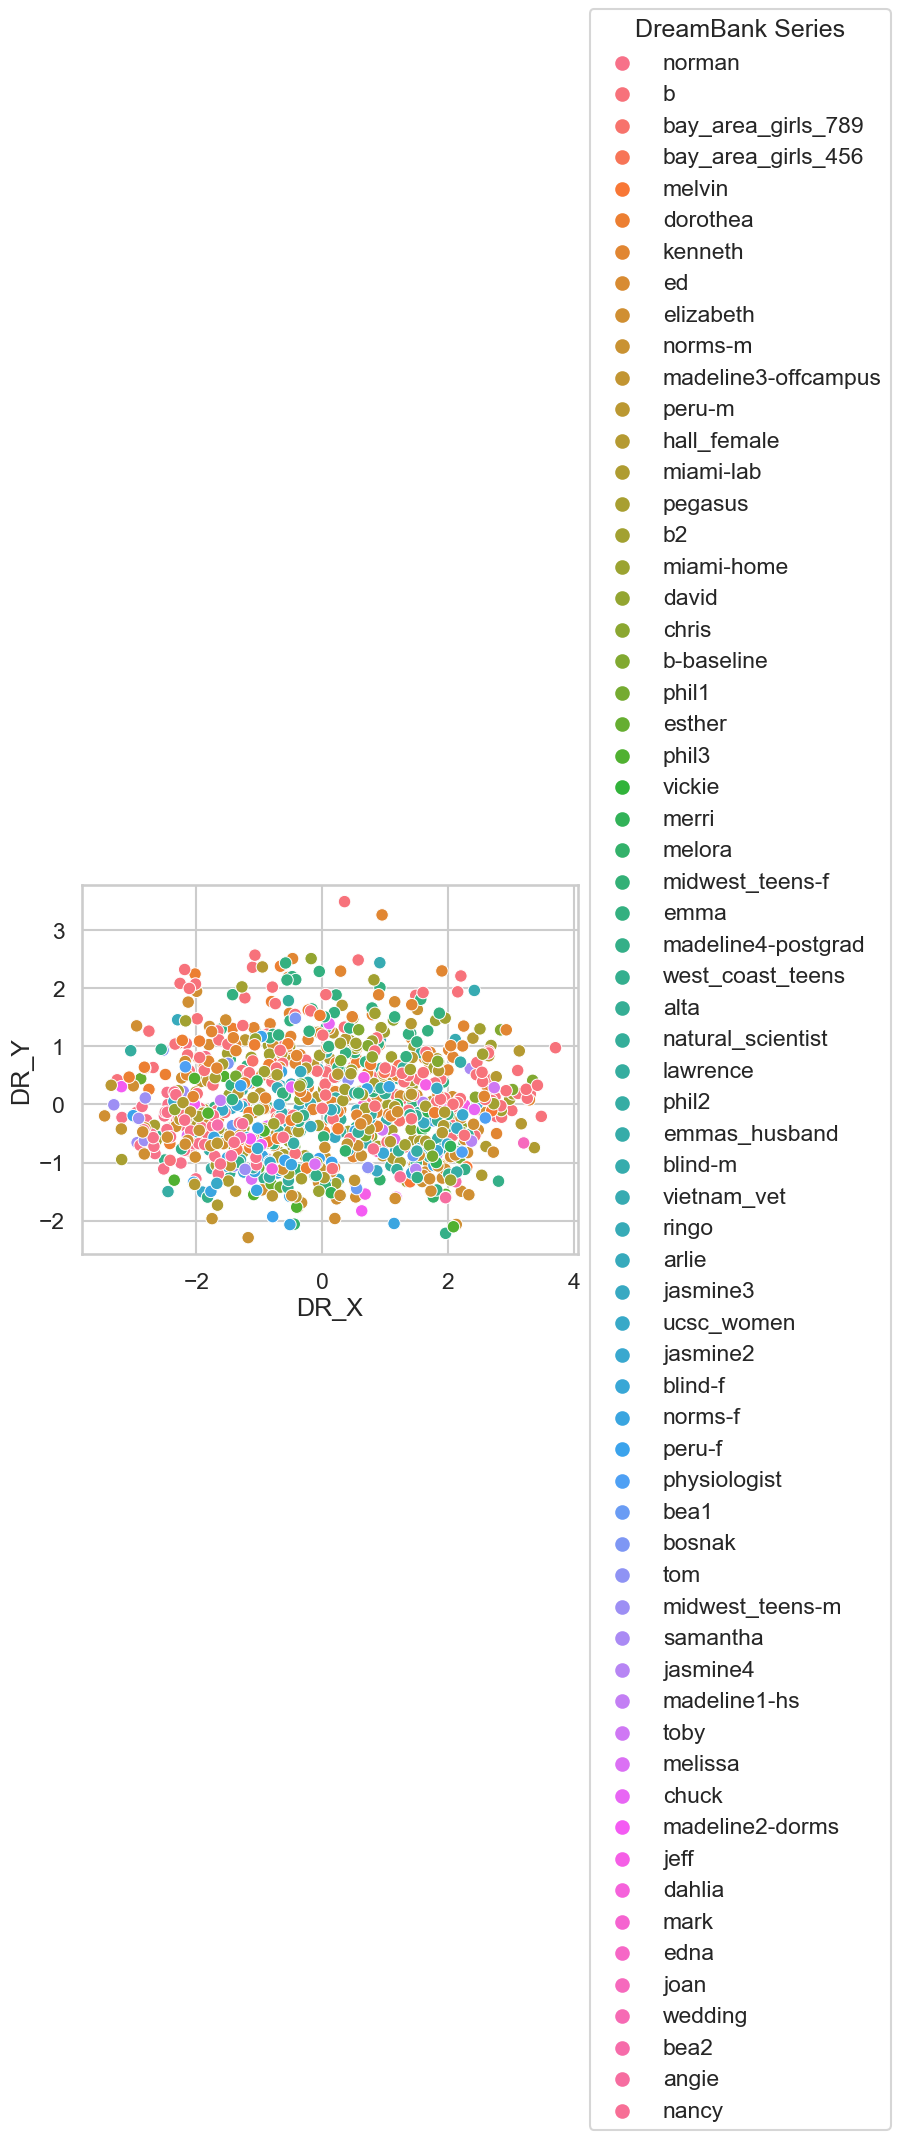

In [ ]:
g = sns.scatterplot(
    data=dream_sample, 
    x="DR_X", 
    y="DR_Y", 
    hue="series",
)

g.legend(loc='center left', title="DreamBank Series", bbox_to_anchor=(1, 0.5))

Aside from simple plotting, we can also use `dreamy` to search for *actual* cluster, using the K-Mean algorithm. We can do so by simply calling the `get_KMeans()` method, as shown below. Let's start by testing if the algorithm can detect the gender of each participant.

In [ ]:
n_clusters = 2

binary_labels = dreamy.get_KMeans(report_encodings, n_clusters)
dream_sample["KM_binary"] = binary_labels

/Users/lb540/miniconda3/envs/dreamypy_test/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


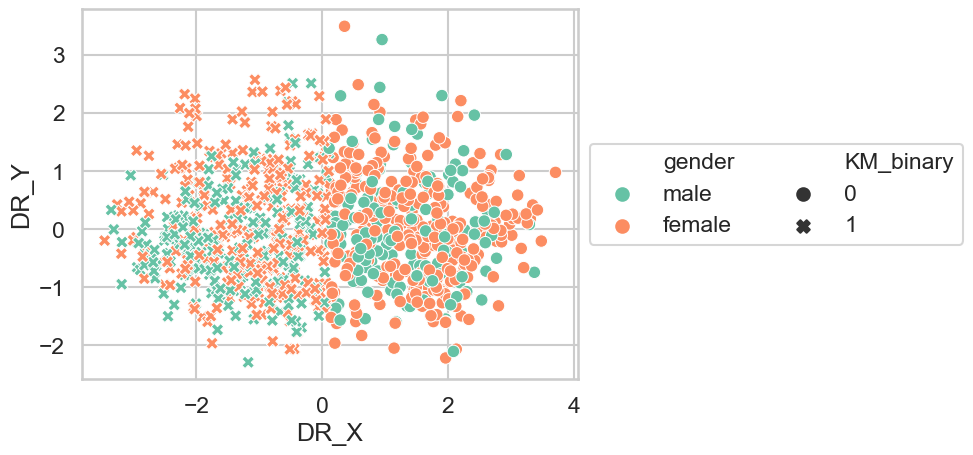

In [ ]:
g = sns.scatterplot(
    data=dream_sample, 
    x="DR_X", 
    y="DR_Y", 
    hue="gender",
    palette="Set2",
    style="KM_binary",
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

From the figure, we can clearly see that the algorithm has identified two clearly distinct religions in the reports' space. However, these don't seem to correlate at all with the gender of each dreamer.